In [153]:
import pandas as pd
import numpy as np
from pathlib import Path
from definitions import ROOT_DIR

In [159]:
def calculate_detected_intensities(df, threshold=0.8):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    Also add detectability column, where compounds with prediction value above threshold=0.8 are labelled as detected (1)
    '''

    df['detectability'] = df.pred_val >= threshold
    vals = df.spot_intensity_bgr_corrected * df.detectability
    df['effective_intensity'] = np.clip(vals, 0, None)
    return df

In [75]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_01June2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

In [154]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                       'name_short', 
                                                       'adduct', 
                                                       'neutral_loss', 
                                                       'pred_val', 
                                                       'spot_intensity_bgr_corrected']]
predictions.neutral_loss.fillna('no neutral loss', inplace=True)

In [232]:
# Add metadata
classes1 = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = classes1[['name_short', 'main_coarse_class']].drop_duplicates()
chem_subclass = classes1[['name_short', 'coarse_class', 'fine_class']] # coarse class here is to do sorting if you want

classes2 = pd.read_csv(p_pathways, index_col='internal_id')
pathways = classes2[['name_short', 'main_coarse_path']].drop_duplicates()
pathway_subclass = classes2[['name_short', 'coarse_path', 'fine_path']] # same here

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'EMBL']]
datasets_info['sample_name'] = datasets_info['Matrix short']

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

In [233]:
df = calculate_detected_intensities(df)

### Here you would also have relevant filtering steps

## Example for any axis values except class, subclass, pathway and pathway subclass

In [179]:
# Aggregate data per metabolite ('name_short'), dataset ('dataset_id') and axis values

# for example
X='adduct'
Y='Matrix short'

step1 = df.pivot_table(index=['dataset_id', 'name_short', X, Y],
            values=['effective_intensity', 'detectability'],
            aggfunc=
                {'effective_intensity':sum,
                'detectability':max},
            fill_value=0)

step1.head()

detectability  \
dataset_id           name_short                adduct Matrix short                  
2021-06-18_10h37m54s 2-Oxoglutaric acid        +Cl    9AA                    True   
                                               -H     9AA                    True   
                                               [M]-   9AA                   False   
                     3-Hydroxyanthranilic acid +Cl    9AA                    True   
                                               -H     9AA                    True   

                                                                    effective_intensity  
dataset_id           name_short                adduct Matrix short                       
2021-06-18_10h37m54s 2-Oxoglutaric acid        +Cl    9AA                     151.03702  
                                               -H     9AA                   65553.20693  
                                               [M]-   9AA                       0.00000  
                     3-Hydroxyanthranilic acid +Cl    9AA                      41.60611  
                                               -H     9AA                    5885.24473

In [180]:
# Aggregate data per dataset  and axis values
# Calculate what fraction metabolites in this dataset were detected with a given X, Y axis value
# There are 172 metaboites in total

n_metabolites = df.name_short.nunique()
step2 = step1.groupby(['dataset_id', X, Y]).agg({
                                                'effective_intensity':'mean',
                                                'detectability': lambda x: sum(x)/n_metabolites}) 


step2.head()

effective_intensity  detectability
dataset_id           adduct Matrix short                                    
2021-06-18_10h37m54s +Cl    9AA                    271.238457       0.360465
                     -H     9AA                  76537.890082       0.779070
                     [M]-   9AA                   1437.505876       0.186047
2021-06-18_10h41m59s +Cl    CHCA                     2.430323       0.029070
                     -H     CHCA                  6039.125376       0.523256

In [181]:
# Finally, take the average of results of all datasets

step3 = step2.groupby([X, Y]).agg({
                                'effective_intensity' : 'mean',
                                'detectability' : 'mean'})

step3['log10_intensity'] = step3['effective_intensity'].apply(lambda x: np.log10(x+1))
step3.head()

effective_intensity  detectability  log10_intensity
adduct Matrix short                                                     
+Cl    9AA                    271.238457       0.360465         2.434949
       CHCA                     2.430323       0.029070         0.535335
       CMBT                     8.212311       0.081395         0.964369
       ClCCA                    0.364440       0.023256         0.134955
       DAN                     88.948965       0.215116         1.953996

<AxesSubplot:xlabel='adduct', ylabel='Matrix short'>

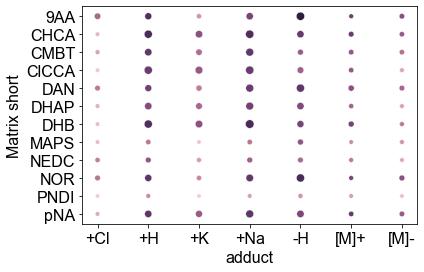

In [189]:
# just a test
import seaborn as sns
sns.scatterplot(data=step3.reset_index(), x=X, y=Y, size='detectability', hue='log10_intensity', legend=False)

## Example for when you have class in axes

- chem_class.main_chem_class are chemical classes
- chem_subclass.fine_class are chemical subclasses
- pathways.main_coarse_path is the main pathway
- pathway_subclass.fine_path is the pathway "subclass"

In [236]:
# Here I use an example of chemical class
# I calcuate the size of the class first

sizes = chem_class.main_coarse_class.value_counts()
chem_class['class_size'] = [sizes[k] for k in chem_class.main_coarse_class]

In [239]:
# Then I merge it with predictions
df = df.merge(chem_class, on='name_short', how='left')

In [265]:
# First step is to  aggregate per metabolite, dataset and axes values

# Let's use matrix and class as example axes values
X='Matrix short'
Y='main_coarse_class'

step1 = df.pivot_table(index=['dataset_id', 'name_short', X, Y],
            values=['effective_intensity', 'detectability', 'class_size'],
            aggfunc=
                {'effective_intensity':'sum',
                'detectability':'max',
                'class_size':'first'},
            fill_value=0)

step1.head()

class_size  \
dataset_id           name_short                   Matrix short main_coarse_class                                     
2021-06-18_10h37m54s 2-Oxoglutaric acid           9AA          Carboxylic acids                                 19   
                     3-Hydroxyanthranilic acid    9AA          Amino acids, peptides, and analogues             47   
                     3-Hydroxymethylglutaric acid 9AA          Carboxylic acids                                 19   
                     3-Phosphoglyceric acid       9AA          Carboxylic acids                                 19   
                     4,5-Dihydroorotic acid       9AA          Nucleosides, nucleotides, and analogues          25   

                                                                                                        detectability  \
dataset_id           name_short                   Matrix short main_coarse_class                                        
2021-06-18_10h37m54s 2-Oxoglutaric acid           9AA          Carboxylic acids                                  True   
                     3-Hydroxyanthranilic acid    9AA          Amino acids, peptides, and analogues              True   
                     3-Hydroxymethylglutaric acid 9AA          Carboxylic acids                                 False   
                     3-Phosphoglyceric acid       9AA          Carboxylic acids                                  True   
                     4,5-Dihydroorotic acid       9AA          Nucleosides, nucleotides, and analogues           True   

                                                                                                        effective_intensity  
dataset_id           name_short                   Matrix short main_coarse_class                                             
2021-06-18_10h37m54s 2-Oxoglutaric acid           9AA          Carboxylic acids                                65704.243950  
                     3-Hydroxyanthranilic acid    9AA          Amino acids, peptides, and analogues             8473.933785  
                     3-Hydroxymethylglutaric acid 9AA          Carboxylic acids                                    0.000000  
                     3-Phosphoglyceric acid       9AA          Carboxylic acids                               164535.047480  
                     4,5-Dihydroorotic acid       9AA          Nucleosides, nucleotides, and analogues        110215.133760

In [258]:
# Next, aggregare per dataset and axes values

step2 = step1.pivot_table(index=['dataset_id', X,Y],
                      values=['effective_intensity', 'detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'effective_intensity':'mean',
                                'detectability':'sum'
                                },
                      fill_value=0,
                      sort=False)

step2['fraction_detected'] = step2.detectability / step2.class_size
step2.head()

class_size  \
dataset_id           main_coarse_class                       Matrix short               
2021-06-18_10h37m54s Carboxylic acids                        9AA                   19   
                     Amino acids, peptides, and analogues    9AA                   47   
                     Nucleosides, nucleotides, and analogues 9AA                   25   
                     Carbohydrates                           9AA                   17   
                     Vitamins and cofactors                  9AA                   16   

                                                                           detectability  \
dataset_id           main_coarse_class                       Matrix short                  
2021-06-18_10h37m54s Carboxylic acids                        9AA                      17   
                     Amino acids, peptides, and analogues    9AA                      44   
                     Nucleosides, nucleotides, and analogues 9AA                      24   
                     Carbohydrates                           9AA                      16   
                     Vitamins and cofactors                  9AA                      11   

                                                                           effective_intensity  \
dataset_id           main_coarse_class                       Matrix short                        
2021-06-18_10h37m54s Carboxylic acids                        9AA                  63428.779576   
                     Amino acids, peptides, and analogues    9AA                  30208.252684   
                     Nucleosides, nucleotides, and analogues 9AA                 200082.596458   
                     Carbohydrates                           9AA                  72808.029444   
                     Vitamins and cofactors                  9AA                  48299.730815   

                                                                           fraction_detected  
dataset_id           main_coarse_class                       Matrix short                     
2021-06-18_10h37m54s Carboxylic acids                        9AA                    0.894737  
                     Amino acids, peptides, and analogues    9AA                    0.936170  
                     Nucleosides, nucleotides, and analogues 9AA                    0.960000  
                     Carbohydrates                           9AA                    0.941176  
                     Vitamins and cofactors                  9AA                    0.687500

In [259]:
# Finally, take the average of results of all datasets

step3 = step2.groupby([X, Y]).agg({
                                'effective_intensity' : 'mean',
                                'fraction_detected' : 'mean'})

step3['log10_intensity'] = step3['effective_intensity'].apply(lambda x: np.log10(x+1))
step3.head()

effective_intensity  fraction_detected  \
main_coarse_class Matrix short                                           
Amines            9AA                  43511.680644           0.500000   
                  CHCA                 73356.518744           0.458333   
                  CMBT                  6224.726942           0.458333   
                  ClCCA                 8140.843461           0.458333   
                  DAN                   9472.869896           0.500000   

                                log10_intensity  
main_coarse_class Matrix short                   
Amines            9AA                  4.638616  
                  CHCA                 4.865445  
                  CMBT                 3.794190  
                  ClCCA                3.910723  
                  DAN                  3.976527

<AxesSubplot:xlabel='Matrix short', ylabel='main_coarse_class'>

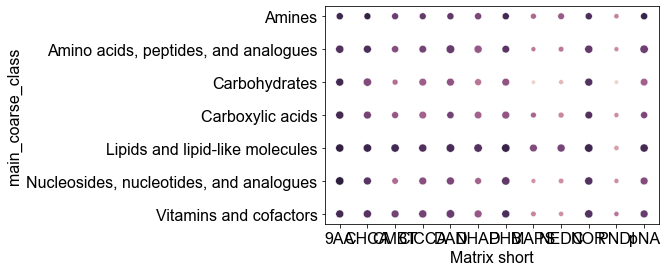

In [266]:
# just a test
sns.scatterplot(data=step3.reset_index(), x=X, y=Y, size='fraction_detected', hue='log10_intensity', legend=False)